In [58]:
from sklearn.metrics import roc_auc_score, roc_curve
from neptune.integrations.lightgbm import NeptuneCallback, create_booster_summary
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, date
import seaborn as sns
import lightgbm as lgb
import numpy as np
import pandas as pd
import neptune


# Load Data
* Handle missing values, duplicated values, outlier

In [59]:
total = pd.read_csv("https://raw.githubusercontent.com/lavibula/ML20222.PredictionBitcoin/main/data/saved_data_ASC.csv")
total['Date'] = pd.to_datetime(total['Date'])

df = total.set_index('Date')
df.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-20,0.1,0.1,0.1,0.1,0.26,936.0,182.0,1090.745856,789700.0,0.000000,...,0.0,0.0,0.0,0.0,1191.7,17.693,0.00,1083.48,10229.96,9300.46
2010-07-21,0.1,0.1,0.1,0.1,0.58,784.0,182.0,603.821256,499964.0,0.000000,...,0.0,0.0,0.0,0.0,1191.8,17.803,0.00,1069.59,10120.53,9278.83
2010-07-22,0.1,0.1,0.1,0.1,2.16,594.0,182.0,572.443182,403000.0,0.000000,...,0.0,0.0,0.0,0.0,1195.6,18.120,7002.75,1093.67,10322.30,9220.88
2010-07-23,0.1,0.1,0.1,0.1,2.40,655.0,182.0,530.932990,412004.0,0.000606,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96
2010-07-24,0.1,0.1,0.1,0.1,0.50,959.0,182.0,1519.539683,1148772.0,0.000000,...,0.0,0.0,0.0,0.0,1187.8,18.101,7018.25,1102.66,10424.62,9430.96


In [60]:
df.shape

(4654, 23)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4654 entries, 2010-07-20 to 2023-04-16
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   BTC_close                   4654 non-null   float64
 1   BTC_open                    4654 non-null   float64
 2   BTC_high                    4654 non-null   float64
 3   BTC_low                     4654 non-null   float64
 4   BTC_volume                  4654 non-null   float64
 5   Active_Addr_Cnt             4654 non-null   float64
 6   Difficulty                  4654 non-null   float64
 7   Mean_Block_Size(in_bytes)   4654 non-null   float64
 8   Sum_Block_Weight            4654 non-null   float64
 9   Total_Fees(USD)             4654 non-null   float64
 10  Mean_Hashrate               4654 non-null   float64
 11  Xfer_Cnt                    4654 non-null   float64
 12  Mean_Tx_size(native_units)  4654 non-null   float64
 13  ETH            

In [62]:
df.describe()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
count,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4.654000e+03,4.654000e+03,4.654000e+03,4.654000e+03,4.654000e+03,...,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000,4654.000000
mean,8950.828126,8944.396197,9182.648904,8680.543532,144.272183,4.974545e+05,7.399910e+12,6.883463e+05,3.329426e+08,5.498044e+05,...,505.010290,45.052975,0.026408,0.229873,1474.337129,21.657901,7112.199345,2492.349280,21487.496401,18751.425404
std,14517.759120,14515.100053,14900.138248,14078.916437,199.685947,3.731797e+05,1.103629e+13,4.990862e+05,2.151278e+08,1.528054e+06,...,945.449318,63.364718,0.069391,0.334681,253.778406,6.479395,1491.343889,989.044608,7511.506584,6322.971966
min,0.100000,0.100000,0.100000,0.000000,0.170000,4.080000e+02,1.820000e+02,4.164167e+02,2.841400e+05,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,1049.600000,11.772000,0.000000,1047.220000,9985.810000,8160.010000
25%,140.475000,140.400000,145.800000,135.825000,25.407500,8.702175e+04,1.322172e+08,1.656955e+05,1.124594e+08,3.741492e+03,...,0.000000,0.000000,0.000000,0.000000,1260.025000,16.624500,5947.125000,1697.435000,15464.300000,14313.030000
50%,916.050000,915.050000,934.150000,877.350000,63.605000,5.389900e+05,2.840750e+11,7.887917e+05,4.066180e+08,6.090908e+04,...,12.430000,3.870000,0.000000,0.008870,1371.850000,19.570000,6962.000000,2204.720000,19161.280000,19435.830000
75%,9932.450000,9926.450000,10231.950000,9636.050000,158.375000,8.174050e+05,1.389755e+13,1.087807e+06,5.072356e+08,4.321621e+05,...,396.107500,67.199500,0.003335,0.350712,1721.025000,25.340750,8151.437500,3046.155000,26828.202500,22902.512500
max,67527.900000,67528.700000,68990.600000,66334.900000,999.530000,1.366494e+06,4.788780e+13,2.535436e+06,7.584308e+08,2.139776e+07,...,4808.380000,386.820000,0.686880,2.780000,2069.400000,48.599000,10674.000000,4796.560000,36799.650000,30670.100000


<Axes: >

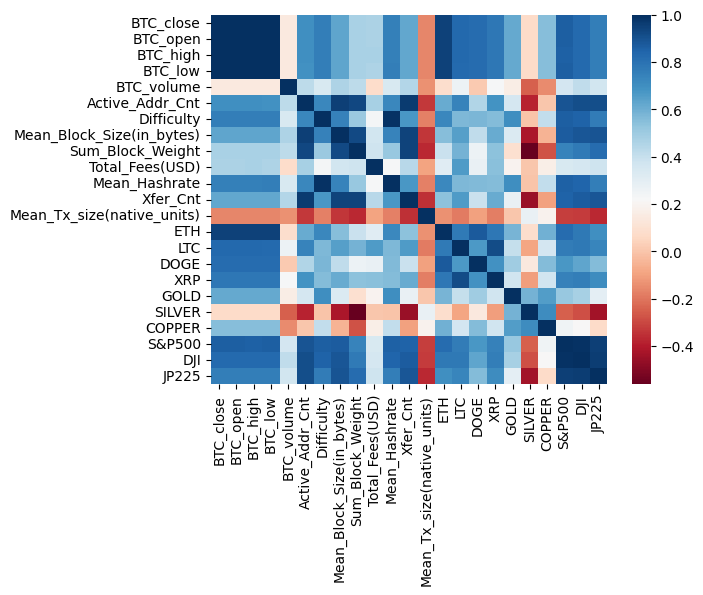

In [63]:
sns.heatmap(df.corr(), cmap="RdBu")

# Slpit Data (Testing, Training Data Sets)

In [89]:
from datetime import datetime
Start_day = date(2016, 3, 10)
End_day = date(2023,4,16)
# train, test

for index in total.index:
    total.loc[index, "Date"] = datetime.strptime(str(total.loc[index, "Date"])[:10], '%Y-%m-%d').date()
total = total[(total["Date"] >= Start_day) & (total["Date"] <= End_day)].reset_index(drop = True)
X = total.drop(["Date"], axis=1)[:-1]
y = total["BTC_close"][1:]

In [90]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# In thông tin kích thước các tập dữ liệu
print("Kích thước X_train:", X_train.shape)
print("Kích thước y_train:", y_train.shape)
print("Kích thước X_test:", X_test.shape)
print("Kích thước y_test:", y_test.shape)

Kích thước X_train: (1944, 23)
Kích thước y_train: (1944,)
Kích thước X_test: (649, 23)
Kích thước y_test: (649,)


# Load Model

In [95]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [106]:
SEARCH_PARAMS = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4],
    'max_depth': [10, 15, 20],
    'num_leaves': [20, 32, 40],
    'feature_fraction': [0.6, 0.8, 1.0],
    'subsample': [0.1, 0.2, 0.3]
}

FIXED_PARAMS = {
    'objective': ['regression'],
    'metric': ['rmse'],
    'boosting': ['dart'],
    'num_boost_round': [300],
    'early_stopping_rounds': [30]
}

In [107]:
# Tạo một đối tượng LightGBMRegressor
model = lgb.LGBMRegressor()

# Kết hợp các tham số tìm kiếm và các tham số cố định thành một dict
param_grid = {**SEARCH_PARAMS, **FIXED_PARAMS}

In [ ]:
# Sử dụng GridSearchCV để tìm kiếm siêu tham số tốt nhất
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)


[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] early_stopping_round is set=30, early_stopping_rounds=30 will be ignored. Current value: early_stopping_round=30
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] boosting 

In [ ]:
# In ra bộ siêu tham số tốt nhất và kết quả tương ứng
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

In [ ]:
# Đào tạo mô hình với bộ siêu tham số tốt nhất
best_model = lgb.LGBMRegressor(**grid_search.best_params_)
best_model.fit(X_train, y_train)

In [ ]:
# Đánh giá mô hình trên tập kiểm tra
y_pred = best_model.predict(X_test)
score = mean_squared_error(y_test, y_pred, squared=False)
print("Test Score:", score)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import numpy as np
y_train_pred = best_model.predict(X_train)

y_test = np.array(y_test)

def AUC(y_test, y_pred):
    count = 0
    for i in range(1,len(y_test)):
        if (y_test[i] - y_test[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
            count += 1
    return count/(len(y_test)-1)
print("Test accuracy for train set")
#RMSE
print("Root Mean Square Error (RMSE):", np.sqrt(mean_squared_error(y_train, y_train_pred)))

#MAPE
print("Mean Absolute Percentage Error (MAPE):", mean_absolute_percentage_error(y_train,y_train_pred))
print()

print("Test accuracy for test set")
#RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error (RMSE):", rmse)

#MAPE
mape = mean_absolute_percentage_error(y_test, y_pred)
print(" Mean Absolute Percentage Error (MAPE):", mape)
print()
AUC = AUC(y_test, y_pred)
#AUC
print("AUC test:", AUC)

In [85]:
"""def train_evaluate(search_params):
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    params = {**FIXED_PARAMS, **search_params}
    
    model = lgb.train(params, train_data,
                     valid_sets=[test_data],
                     num_boost_round=FIXED_PARAMS['num_boost_round'],
                     early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
                     valid_names=['test'])
    
    y_pred = model.predict(X_test)
    score = mean_squared_error(y_test, y_pred, squared=False)
    return score"""

In [88]:
"""results = skopt.forest_minimize(objective, SPACE,
                                n_calls=100, n_random_starts=10)
best_score = -results.fun
best_params = results.x
print(f"Best score: {best_score}")
print("Best parameters:")
for name, value in zip(SPACE, best_params):
    print(f"{name.name}: {value}")
"""

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5864
[LightGBM] [Info] Number of data points in the train set: 1944, number of used features: 23
[LightGBM] [Info] Start training from score 10108.981019
[1]	test's rmse: 20435.3
[2]	test's rmse: 15536.1
[3]	test's rmse: 11887.9
[4]	test's rmse: 9458.22
[5]	test's rmse: 7239.79
[6]	test's rmse: 5996.09
[7]	test's rmse: 5001.69
[8]	test's rmse: 5984.95
[9]	test's rmse: 4986.01
[10]	test's rmse: 4124.02
[11]	test's rmse: 3659.3
[12]	test's rmse: 4058.16
[13]	test's rmse: 3490.7
[14]	test's rmse: 3204.63
[15]	test's rmse: 2909.59
[16]	test's rmse: 2799.51
[17]	test's rmse: 2715.01
[18]	test's rmse: 2630.33
[19]	test's rmse: 2622.35
[20]	test's rmse: 2614.33
[21]	test's rmse: 2770.64
[22]	test's rmse: 2725.32
[23]	test's rmse: 2686.37
[24]	test's rmse: 2662.83
[25]	test's rmse: 2665.19
[26]	test's r

[22]	test's rmse: 15707.5
[23]	test's rmse: 15243.5
[24]	test's rmse: 14810.7
[25]	test's rmse: 14395.7
[26]	test's rmse: 13983
[27]	test's rmse: 13571.1
[28]	test's rmse: 13748.6
[29]	test's rmse: 13345.8
[30]	test's rmse: 12979.1
[31]	test's rmse: 13056.9
[32]	test's rmse: 12684
[33]	test's rmse: 12318.8
[34]	test's rmse: 11987.5
[35]	test's rmse: 12205.1
[36]	test's rmse: 12557
[37]	test's rmse: 12193.3
[38]	test's rmse: 11842.3
[39]	test's rmse: 11517.1
[40]	test's rmse: 11472.8
[41]	test's rmse: 11722.2
[42]	test's rmse: 11402.9
[43]	test's rmse: 11627.1
[44]	test's rmse: 11290.5
[45]	test's rmse: 10970.7
[46]	test's rmse: 12394.8
[47]	test's rmse: 12046.4
[48]	test's rmse: 12055.3
[49]	test's rmse: 12314.8
[50]	test's rmse: 12580.7
[51]	test's rmse: 12225.5
[52]	test's rmse: 11899
[53]	test's rmse: 12118.7
[54]	test's rmse: 11779.8
[55]	test's rmse: 11452.9
[56]	test's rmse: 11743.3
[57]	test's rmse: 11408.1
[58]	test's rmse: 12781.5
[59]	test's rmse: 13072.9
[60]	test's rmse: 12

[81]	test's rmse: 12395.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	test's rmse: 12063.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	test's rmse: 12279.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	test's rmse: 12469.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	test's rmse: 12668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	test's rmse: 12338.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	test's rmse: 12004.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	test's rmse: 12234.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	test's rmse: 12387.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	test's rmse: 12581.5
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	test's rmse: 8494.81
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	test's rmse: 8288.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	test's rmse: 8460.35
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	test's rmse: 8614.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	test's rmse: 8768.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	test's rmse: 8548.89
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	test's rmse: 8679.53
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	test's rmse: 8970.63
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	test's rmse: 8746.17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	t

[278]	test's rmse: 5904.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	test's rmse: 5774.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	test's rmse: 5903.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	test's rmse: 6104.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	test's rmse: 5964.79
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	test's rmse: 6082.17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	test's rmse: 5951.84
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[285]	test's rmse: 5822.93
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[286]	test's rmse: 5702.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[287]	test's rmse: 5581.35
[LightGBM] [Warning] No further splits with positive ga

[267]	test's rmse: 3326.09
[268]	test's rmse: 3311.52
[269]	test's rmse: 3365.79
[270]	test's rmse: 3341.2
[271]	test's rmse: 3374.74
[272]	test's rmse: 3348.07
[273]	test's rmse: 3314.82
[274]	test's rmse: 3345.45
[275]	test's rmse: 3333.54
[276]	test's rmse: 3361.32
[277]	test's rmse: 3335.23
[278]	test's rmse: 3369.46
[279]	test's rmse: 3326.94
[280]	test's rmse: 3368.28
[281]	test's rmse: 3453.23
[282]	test's rmse: 3402.42
[283]	test's rmse: 3434.87
[284]	test's rmse: 3387.6
[285]	test's rmse: 3349.3
[286]	test's rmse: 3320.9
[287]	test's rmse: 3303.01
[288]	test's rmse: 3336.76
[289]	test's rmse: 3315.42
[290]	test's rmse: 3299.72
[291]	test's rmse: 3291.54
[292]	test's rmse: 3320.36
[293]	test's rmse: 3351.74
[294]	test's rmse: 3318.08
[295]	test's rmse: 3349.98
[296]	test's rmse: 3388.04
[297]	test's rmse: 3357.28
[298]	test's rmse: 3399.25
[299]	test's rmse: 3367.21
[300]	test's rmse: 3398.24
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing w

[275]	test's rmse: 5210.42
[276]	test's rmse: 5333.89
[277]	test's rmse: 5212.11
[278]	test's rmse: 5328.17
[279]	test's rmse: 5214.03
[280]	test's rmse: 5339.43
[281]	test's rmse: 5537.4
[282]	test's rmse: 5418.97
[283]	test's rmse: 5531.76
[284]	test's rmse: 5416.54
[285]	test's rmse: 5296.91
[286]	test's rmse: 5181.18
[287]	test's rmse: 5070.83
[288]	test's rmse: 5192.97
[289]	test's rmse: 5075.98
[290]	test's rmse: 4968.94
[291]	test's rmse: 4875.55
[292]	test's rmse: 4992.84
[293]	test's rmse: 5102.58
[294]	test's rmse: 4992.87
[295]	test's rmse: 5107.93
[296]	test's rmse: 5220.47
[297]	test's rmse: 5106.58
[298]	test's rmse: 5217.38
[299]	test's rmse: 5109.7
[300]	test's rmse: 5211.74
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5864
[LightGBM] [Info] Number of data points in the train set: 1944, number of used features: 23
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	test's rmse: 5166.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	test's rmse: 4952.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	test's rmse: 4928.73
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	test's rmse: 4911.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	test's rmse: 4919.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	test's rmse: 4920.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	test's rmse: 4943.93
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	test's rmse: 5006.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	test's rmse: 5026.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	test's rmse: 5

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	test's rmse: 5473.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	test's rmse: 5465.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	test's rmse: 5480.04
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	test's rmse: 5487.97
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	test's rmse: 5478.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	test's rmse: 5468.71
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	test's rmse: 5472.55
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	test's rmse: 5469.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	test's rmse: 5481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	test'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	test's rmse: 5602.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	test's rmse: 5612.29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	test's rmse: 5604.15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	test's rmse: 5604.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	test's rmse: 5596.15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	test's rmse: 5612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	test's rmse: 5624.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	test's rmse: 5641.99
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	test's rmse: 5626.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	test

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	test's rmse: 6755.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	test's rmse: 6392.33
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	test's rmse: 6427.19
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	test's rmse: 6591.24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[78]	test's rmse: 6870.93
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[79]	test's rmse: 6507.68
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[80]	test's rmse: 6202.03
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[81]	test's rmse: 6424.76
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[82]	test's rmse: 6099.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	test's rmse

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	test's rmse: 4338.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	test's rmse: 4194.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	test's rmse: 4065.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	test's rmse: 3942.59
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	test's rmse: 4103.14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	test's rmse: 4255.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	test's rmse: 4123.21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	test's rmse: 3994.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	test's rmse: 3884.46
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	te

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	test's rmse: 3509.48
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	test's rmse: 3577.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	test's rmse: 3515.84
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	test's rmse: 3589.46
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	test's rmse: 3530.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	test's rmse: 3593.34
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5864
[LightGBM] [Info] Number of data points in the train set: 1944, number of used features: 23
[LightGBM] [Info] Start training from score 10108.981019
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	test's rmse: 6555.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	test's rmse: 6122.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	test's rmse: 6275.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	test's rmse: 6447.41
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	test's rmse: 6020.05
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	test's rmse: 5661.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	test's rmse: 5448.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	test's rmse: 5265.15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	test's rmse: 5111.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	te

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	test's rmse: 4678.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	test's rmse: 4631.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	test's rmse: 4669.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	test's rmse: 4714.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	test's rmse: 4758.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	test's rmse: 4714.22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	test's rmse: 4754.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	test's rmse: 4849.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	test's rmse: 4792.03
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	tes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[288]	test's rmse: 4772.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	test's rmse: 4766.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	test's rmse: 4754.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	test's rmse: 4759.01
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	test's rmse: 4769.66
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	test's rmse: 4780.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	test's rmse: 4786.29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	test's rmse: 4805.14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	test's rmse: 4818.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	tes

[91]	test's rmse: 4495.67
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	test's rmse: 4112.91
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	test's rmse: 3828.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	test's rmse: 3947.79
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	test's rmse: 4077.98
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	test's rmse: 4167.48
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[97]	test's rmse: 3886.96
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[98]	test's rmse: 4078.45
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[99]	test's rmse: 3817.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	test's rmse: 3563.21
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	test's rmse: 3268.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	test's rmse: 3222.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	test's rmse: 3213.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	test's rmse: 3221.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	test's rmse: 3270.53
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	test's rmse: 3320.71
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	test's rmse: 3264.91
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	test's rmse: 3252.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	test's rmse: 3230.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	tes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[289]	test's rmse: 3376.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[290]	test's rmse: 3358.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[291]	test's rmse: 3352.24
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[292]	test's rmse: 3370.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[293]	test's rmse: 3387.54
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[294]	test's rmse: 3374.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[295]	test's rmse: 3395.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[296]	test's rmse: 3417.58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[297]	test's rmse: 3385.06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[298]	tes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	test's rmse: 22360.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	test's rmse: 22143.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	test's rmse: 22225.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	test's rmse: 22317.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	test's rmse: 22101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	test's rmse: 21883.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	test's rmse: 21677.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	test's rmse: 21466
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[115]	test's rmse: 21255.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	test'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	test's rmse: 18222.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	test's rmse: 18331.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	test's rmse: 18434.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	test's rmse: 18256.6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	test's rmse: 18344.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	test's rmse: 18593.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	test's rmse: 18413.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	test's rmse: 18509.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	test's rmse: 18339.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	t

InvalidParameterError: The 'criterion' parameter of ExtraTreesRegressor must be a str among {'absolute_error', 'poisson', 'friedman_mse', 'squared_error'}. Got 'mse' instead.